In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
import lightgbm as lgb

# To suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load telemetry training data
train = pd.read_csv('dataset/telemetry_for_operations_training.csv', parse_dates=['create_dt'])

# Load labels training data
labels = pd.read_csv('dataset/operations_labels_training.csv', parse_dates=['start_time', 'end_time'])

# Load telemetry validation data
val = pd.read_csv('dataset/telemetry_for_operations_validation.csv', parse_dates=['create_dt'])


In [3]:
print("Missing values in telemetry_train:", train.isnull().sum().sum())
print("Missing values in labels_train:", labels.isnull().sum().sum())
print("Missing values in telemetry_val:", val.isnull().sum().sum())


Missing values in telemetry_train: 0
Missing values in labels_train: 0
Missing values in telemetry_val: 0


In [4]:
# Already parsed dates during read_csv using parse_dates
# Convert categorical columns if necessary
train['mdm_object_name'] = train['mdm_object_name'].astype('category')
labels['mdm_object_name'] = labels['mdm_object_name'].astype('category')
val['mdm_object_name'] = val['mdm_object_name'].astype('category')

In [5]:
# train count and drop lat and lon values greater than 180 and - 180
print("Number of rows in train before dropping:", train.shape[0])
train = train[(train['lat'] <= 180) & (train['lat'] >= -180)]
train = train[(train['lon'] <= 180) & (train['lon'] >= -180)]
print("Number of rows in train after dropping:", train.shape[0])

Number of rows in train before dropping: 516073
Number of rows in train after dropping: 515774


In [6]:
train.dtypes

create_dt              object
mdm_object_name      category
mdm_model_id            int64
lon                   float64
lat                   float64
alt                     int64
speed_gps             float64
direction             float64
accel_forward_nn      float64
accel_braking_nn      float64
accel_angular_nn      float64
accel_vertical_nn     float64
dtype: object

In [7]:
labels.dtypes

start_time           datetime64[ns]
end_time             datetime64[ns]
operation_kind_id             int64
mdm_object_name            category
name                         object
dtype: object

In [8]:
train['create_dt'] = pd.to_datetime(train['create_dt'] , format='mixed')

In [36]:
val['create_dt'] = pd.to_datetime(val['create_dt'] , format='mixed')

In [9]:
train['create_dt'][116483]

Timestamp('2023-09-21 00:00:00')

In [10]:
train = train.drop_duplicates()

In [11]:
labels['start_time'] = pd.to_datetime(labels['start_time'])


In [12]:
# Sort both dataframes by time
train1 = train.sort_values(['mdm_object_name', 'create_dt']).reset_index(drop=True)

In [13]:
labels1 = labels.sort_values(['mdm_object_name', 'start_time']).reset_index(drop=True)

In [14]:
print(train1.dtypes)
print(labels1.dtypes)

create_dt            datetime64[ns]
mdm_object_name            category
mdm_model_id                  int64
lon                         float64
lat                         float64
alt                           int64
speed_gps                   float64
direction                   float64
accel_forward_nn            float64
accel_braking_nn            float64
accel_angular_nn            float64
accel_vertical_nn           float64
dtype: object
start_time           datetime64[ns]
end_time             datetime64[ns]
operation_kind_id             int64
mdm_object_name            category
name                         object
dtype: object


In [15]:
#check if sorted correctly 
train1.head()

,create_dt,mdm_object_name,mdm_model_id,lon,lat,alt,speed_gps,direction,accel_forward_nn,accel_braking_nn,accel_angular_nn,accel_vertical_nn
0,2023-09-26 08:00:12,119,61,0.007798,0.00168,-90,0.0,19.1,0.0,0.0,0.0,0.0
1,2023-09-26 08:00:17,119,61,0.007798,0.00168,-90,0.0,19.1,0.0,0.0,0.0,0.0
2,2023-09-26 08:00:22,119,61,0.007798,0.00168,-90,0.0,19.1,0.0,0.0,0.0,0.0
3,2023-09-26 08:00:27,119,61,0.007798,0.00168,-90,0.0,19.1,0.0,0.0,0.0,0.0
4,2023-09-26 08:00:32,119,61,0.007798,0.00168,-90,0.0,19.1,0.0,0.0,0.0,0.0


In [16]:
labels1.head()

,start_time,end_time,operation_kind_id,mdm_object_name,name
0,2023-09-26 08:00:12,2023-09-26 08:03:12,0,119,idle
1,2023-09-26 08:03:12,2023-09-26 08:08:11,1,119,loading
2,2023-09-26 08:08:11,2023-09-26 08:26:28,2,119,riding_loaded
3,2023-09-26 08:26:28,2023-09-26 08:26:58,3,119,unloading_lift
4,2023-09-26 08:27:30,2023-09-26 08:38:42,5,119,riding_empty


In [20]:
train1= train1.sort_values(['create_dt']).reset_index(drop=True)

In [21]:
labels1= labels1.sort_values(['start_time']).reset_index(drop=True)

In [22]:
merged_train = pd.merge_asof(
    train1,
    labels1,
    left_on='create_dt',
    right_on='start_time',
    by='mdm_object_name',
    direction='backward',
    allow_exact_matches=True
)

In [23]:
merged_train.head()

,create_dt,mdm_object_name,mdm_model_id,lon,lat,alt,speed_gps,direction,accel_forward_nn,accel_braking_nn,accel_angular_nn,accel_vertical_nn,start_time,end_time,operation_kind_id,name
0,2023-08-09 08:02:54,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,0.0,0.0,2023-08-09 08:02:54,2023-08-09 08:10:05,0,idle
1,2023-08-09 08:02:59,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,0.0,0.0,2023-08-09 08:02:54,2023-08-09 08:10:05,0,idle
2,2023-08-09 08:03:04,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,0.0,0.0,2023-08-09 08:02:54,2023-08-09 08:10:05,0,idle
3,2023-08-09 08:03:09,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,0.0,0.0,2023-08-09 08:02:54,2023-08-09 08:10:05,0,idle
4,2023-08-09 08:03:14,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,0.0,0.0,2023-08-09 08:02:54,2023-08-09 08:10:05,0,idle


In [24]:
print(train1.shape)
print(merged_train.shape)

(500888, 12)
(500888, 16)


In [25]:
# Assign operational state where create_dt <= end_time
mask = merged_train['create_dt'] <= merged_train['end_time']
merged_train = merged_train[mask]

In [26]:
merged_train.shape

(493215, 16)

In [27]:
merged_train.isna().sum()

create_dt            0
mdm_object_name      0
mdm_model_id         0
lon                  0
lat                  0
alt                  0
speed_gps            0
direction            0
accel_forward_nn     0
accel_braking_nn     0
accel_angular_nn     0
accel_vertical_nn    0
start_time           0
end_time             0
operation_kind_id    0
name                 0
dtype: int64

In [28]:
merged_train.dtypes

create_dt            datetime64[ns]
mdm_object_name            category
mdm_model_id                  int64
lon                         float64
lat                         float64
alt                           int64
speed_gps                   float64
direction                   float64
accel_forward_nn            float64
accel_braking_nn            float64
accel_angular_nn            float64
accel_vertical_nn           float64
start_time           datetime64[ns]
end_time             datetime64[ns]
operation_kind_id             int64
name                         object
dtype: object

In [29]:
merged_train['month'] = merged_train['create_dt'].dt.month
merged_train['day'] = merged_train['create_dt'].dt.day
merged_train['hour'] = merged_train['create_dt'].dt.hour
merged_train['minute'] = merged_train['create_dt'].dt.minute
merged_train['second'] = merged_train['create_dt'].dt.second
merged_train['day_of_week'] = merged_train['create_dt'].dt.dayofweek 
# Cyclical encoding for hour (repeat every 24 hours)
merged_train['hour_sin'] = np.sin(2 * np.pi * merged_train['hour'] / 24)
merged_train['hour_cos'] = np.cos(2 * np.pi * merged_train['hour'] / 24)

# Cyclical encoding for day of the week (repeat every 7 days)
merged_train['day_of_week_sin'] = np.sin(2 * np.pi * merged_train['day_of_week'] / 7)
merged_train['day_of_week_cos'] = np.cos(2 * np.pi * merged_train['day_of_week'] / 7)


In [37]:
val['month'] = val['create_dt'].dt.month
val['day'] = val['create_dt'].dt.day
val['hour'] = val['create_dt'].dt.hour
val['minute'] = val['create_dt'].dt.minute
val['second'] = val['create_dt'].dt.second
val['day_of_week'] = val['create_dt'].dt.dayofweek 
#valncoding for hour (repeat every 24 hours)
val['hour_sin'] = np.sin(2 * np.pi * val['hour'] / 24)
val['hour_cos'] = np.cos(2 * np.pi * val['hour'] / 24)
#valncoding for day of the week (repeat every 7 days)
val['day_of_week_sin'] = np.sin(2 * np.pi * val['day_of_week'] / 7)
val['day_of_week_cos'] = np.cos(2 * np.pi * val['day_of_week'] / 7)


In [38]:
print(merged_train.shape)
print(val.shape)

(493215, 26)
(260111, 22)


In [95]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# # Select the features for clustering
# X = merged_train[['lon', 'lat']]
# inertia = []

# # Calculate inertia for different numbers of clusters
# for n_clusters in range(1, 15):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     kmeans.fit(X)
#     inertia.append(kmeans.inertia_)

# # Plot the inertia values
# plt.plot(range(1, 15), inertia, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.title('KMeans Elbow Method')
# plt.show()

# # Print the inertia values for reference
# print("Inertia values:", inertia)

KeyboardInterrupt: 

Calculating Silhouette Score: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]


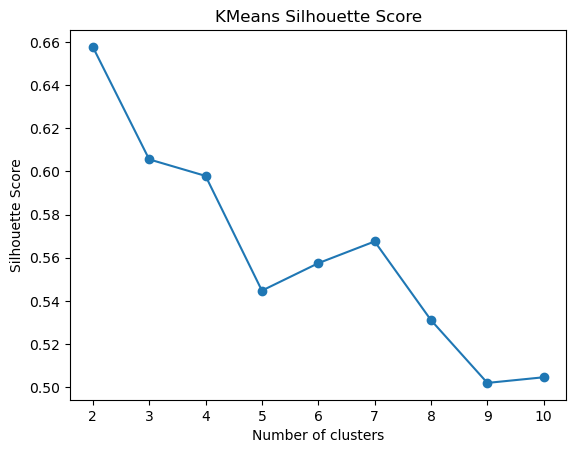

The optimal number of clusters is: 2


In [90]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from tqdm import tqdm

# # Assuming X is your data
# # X = ...

# silhouette = []

# for n_clusters in tqdm(range(2, 11), desc='Calculating Silhouette Score'):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     kmeans.fit(X)
#     silhouette.append(silhouette_score(X, kmeans.labels_,sample_size=10000))

# # Plot the silhouette scores
# plt.plot(range(2, 11), silhouette, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette Score')
# plt.title('KMeans Silhouette Score')
# plt.show()

# # Find the optimal number of clusters
# optimal_clusters = range(2, 11)[silhouette.index(max(silhouette))]
# print(f"The optimal number of clusters is: {optimal_clusters}")

In [96]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=2, random_state=42)
# merged_train['location_cluster'] = kmeans.fit_predict(merged_train[['lon','lat']])

In [97]:
merged_train.dtypes

create_dt            datetime64[ns]
mdm_object_name            category
mdm_model_id                  int64
lon                         float64
lat                         float64
alt                           int64
speed_gps                   float64
direction                   float64
accel_forward_nn            float64
accel_braking_nn            float64
accel_angular_nn            float64
accel_vertical_nn           float64
start_time           datetime64[ns]
end_time             datetime64[ns]
operation_kind_id             int64
name                         object
month                         int32
day                           int32
hour                          int32
minute                        int32
second                        int32
day_of_week                   int32
hour_sin                    float64
hour_cos                    float64
day_of_week_sin             float64
day_of_week_cos             float64
location_cluster              int32
dtype: object

In [55]:
val

,create_dt,mdm_object_name,mdm_model_id,lon,lat,alt,speed_gps,direction,accel_forward_nn,accel_braking_nn,accel_angular_nn,accel_vertical_nn
0,2023-09-29 08:03:27,1501,62,0.015931,-0.002470,-77,8.8,180.0,0.000,0.294,0.000,0.98
1,2023-09-29 08:03:28,1501,62,0.015946,-0.002493,-77,9.7,156.0,0.196,0.000,0.000,0.98
2,2023-09-29 08:03:33,1501,62,0.016007,-0.002581,-79,11.6,159.0,0.686,0.000,0.000,0.00
3,2023-09-29 08:03:34,1501,62,0.016053,-0.002634,-79,9.9,156.0,0.000,1.176,1.078,0.00
4,2023-09-29 08:03:35,1501,62,0.016084,-0.002657,-80,12.5,138.0,0.686,0.000,1.568,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...
260106,2023-09-30 16:32:25,119,61,-0.041015,0.004648,229,0.0,318.0,0.000,0.000,0.000,0.00
260107,2023-09-30 16:32:30,119,61,-0.041015,0.004648,229,0.0,318.0,0.000,0.000,0.000,0.00
260108,2023-09-30 16:32:35,119,61,-0.041015,0.004648,229,0.0,318.0,0.000,0.000,0.000,0.00
260109,2023-09-30 16:32:40,119,61,-0.041015,0.004648,229,0.0,318.0,0.000,0.000,0.000,0.00


In [31]:
merged_train

,create_dt,mdm_object_name,mdm_model_id,lon,lat,alt,speed_gps,direction,accel_forward_nn,accel_braking_nn,...,month,day,hour,minute,second,day_of_week,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,2023-08-09 08:02:54,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,8,9,8,2,54,2,0.866025,-0.500000,0.974928,-0.222521
1,2023-08-09 08:02:59,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,8,9,8,2,59,2,0.866025,-0.500000,0.974928,-0.222521
2,2023-08-09 08:03:04,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,8,9,8,3,4,2,0.866025,-0.500000,0.974928,-0.222521
3,2023-08-09 08:03:09,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,8,9,8,3,9,2,0.866025,-0.500000,0.974928,-0.222521
4,2023-08-09 08:03:14,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,8,9,8,3,14,2,0.866025,-0.500000,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500835,2023-12-15 15:54:26,125,61,0.007083,0.006013,-55,0.0,270.0,0.0,0.0,...,12,15,15,54,26,4,-0.707107,-0.707107,-0.433884,-0.900969
500836,2023-12-15 15:54:31,125,61,0.007083,0.006013,-55,0.0,270.0,0.0,0.0,...,12,15,15,54,31,4,-0.707107,-0.707107,-0.433884,-0.900969
500837,2023-12-15 15:54:36,125,61,0.007083,0.006013,-55,0.0,270.0,0.0,0.0,...,12,15,15,54,36,4,-0.707107,-0.707107,-0.433884,-0.900969
500838,2023-12-15 15:54:41,125,61,0.007083,0.006013,-55,0.0,270.0,0.0,0.0,...,12,15,15,54,41,4,-0.707107,-0.707107,-0.433884,-0.900969


In [102]:
# percentage_df = merged_train.groupby(['location_cluster', 'operation_kind_id']).size().reset_index(name='count')
# total_counts = merged_train.groupby('location_cluster').size().reset_index(name='total_count')
# percentage_df = percentage_df.merge(total_counts, on='location_cluster')
# percentage_df['percentage'] = (percentage_df['count'] / percentage_df['total_count']) * 100

# print(percentage_df)



   location_cluster  operation_kind_id   count  total_count  percentage
0                 0                  0   17679       185442    9.533439
1                 0                  1   10809       185442    5.828777
2                 0                  2   93676       185442   50.514986
3                 0                  3    2414       185442    1.301755
4                 0                  5   60864       185442   32.821044
5                 1                  0   51612       307773   16.769502
6                 1                  1   19582       307773    6.362481
7                 1                  2  133848       307773   43.489195
8                 1                  3    3892       307773    1.264568
9                 1                  5   98839       307773   32.114253


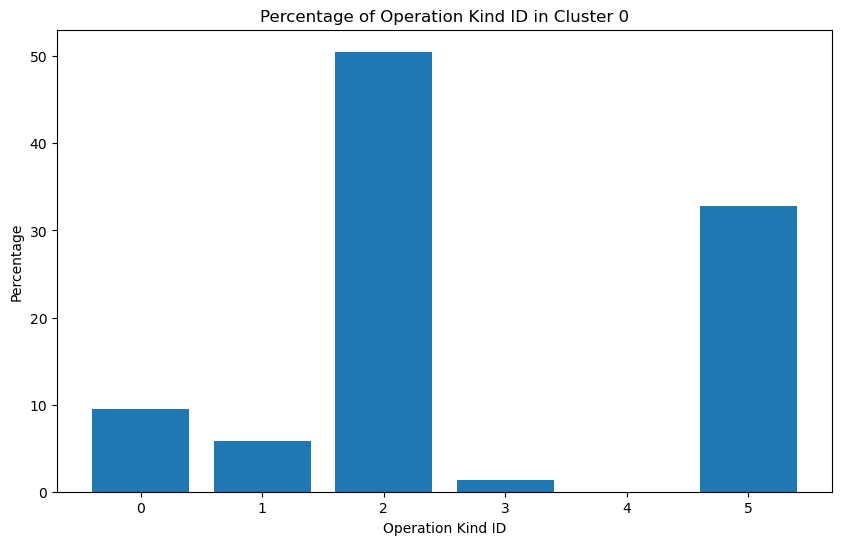

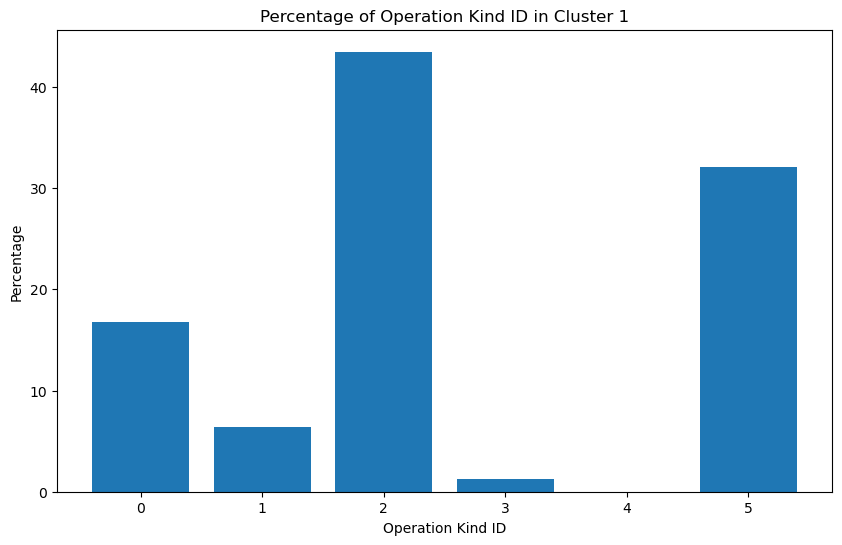

In [106]:
# for cluster in range(2):
#     cluster_data = percentage_df[percentage_df['location_cluster'] == cluster]
#     plt.figure(figsize=(10, 6))
#     plt.bar(cluster_data['operation_kind_id'], cluster_data['percentage'])
#     plt.xlabel('Operation Kind ID')
#     plt.ylabel('Percentage')
#     plt.title(f'Percentage of Operation Kind ID in Cluster {cluster}')
#     plt.show()

In [30]:
merged_train.dtypes

create_dt            datetime64[ns]
mdm_object_name            category
mdm_model_id                  int64
lon                         float64
lat                         float64
alt                           int64
speed_gps                   float64
direction                   float64
accel_forward_nn            float64
accel_braking_nn            float64
accel_angular_nn            float64
accel_vertical_nn           float64
start_time           datetime64[ns]
end_time             datetime64[ns]
operation_kind_id             int64
name                         object
month                         int32
day                           int32
hour                          int32
minute                        int32
second                        int32
day_of_week                   int32
hour_sin                    float64
hour_cos                    float64
day_of_week_sin             float64
day_of_week_cos             float64
dtype: object

In [33]:
train_final = merged_train.drop(columns=['start_time','end_time','name'])

In [40]:
print(train_final.shape)
print(val.shape)

(493215, 23)
(260111, 22)


In [34]:
train_final.to_csv('train_new.csv', index=False)

In [42]:
val.to_csv('val_new.csv', index=False)

In [43]:
train_final.columns

Index(['create_dt', 'mdm_object_name', 'mdm_model_id', 'lon', 'lat', 'alt',
       'speed_gps', 'direction', 'accel_forward_nn', 'accel_braking_nn',
       'accel_angular_nn', 'accel_vertical_nn', 'operation_kind_id', 'month',
       'day', 'hour', 'minute', 'second', 'day_of_week', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [45]:
# list all the model_object_name in train_final and val 
model_object_name_train = train_final['mdm_object_name'].unique()
model_object_name_val = val['mdm_object_name'].unique()


KeyError: 'mdm_object_name'

In [44]:
# Label Encoding for mdm_object_name
le = LabelEncoder()
train_final['mdm_object_name_enc'] = le.fit_transform(train_final['mdm_object_name'])
train_final.drop(columns='mdm_object_name', inplace=True)
val['mdm_object_name_enc'] = le.transform(val['mdm_object_name'])
val.drop(columns='mdm_object_name', inplace=True)

ValueError: y contains previously unseen labels: [1404, 1501]

In [ ]:
le_target = LabelEncoder()
y_train_enc = le_target.fit_transform(y_train)

# To inverse transform later if needed
# y_pred = le_target.inverse_transform(y_pred_enc)
